In [20]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families.links import Identity
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.interpolate as interpolate

## Question 1
### Part A

In [125]:
data = pd.read_excel('lab_2_data.xlsx', sheet_name='Question1')
data = data.iloc[:,1:]
data

,Distance,Speed,Time,Temperature,Fuel Use
0,72.593002,45.353451,1.600606,12.073238,6.045626
1,37.030411,56.019401,0.661028,14.614790,3.735909
2,141.228387,40.810311,3.460605,7.937641,9.800828
3,45.063271,35.192866,1.280466,17.158764,3.486049
4,49.535986,49.092019,1.009044,15.019474,4.330905
...,...,...,...,...,...
145,93.198330,50.023901,1.863076,2.709565,6.785105
146,45.879352,51.981845,0.882603,8.155196,4.169709
147,78.177399,34.138870,2.289982,6.965178,4.732142
148,50.225586,45.053175,1.114807,11.100797,4.048542


### Part B

In [129]:
endog = data['Fuel Use']
exog = data.iloc[:,:4]
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
print(vif_score)

{'const': 313.02995773740986, 'Distance': 70.6630668056125, 'Speed': 5.494948523258741, 'Time': 73.50952738746173, 'Temperature': 1.0239969284527553}


In [131]:
exog = data.loc[:,['Time', 'Speed', 'Temperature']]
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
print(vif_score)

{'const': 74.00194764231799, 'Time': 1.057391139245929, 'Speed': 1.0490157634601847, 'Temperature': 1.013819046875141}


Based on the above VIF scores, collinearity is detected for Distance and Time - but NOT for Speed and Temperature. After removing distance, we run the check again and see Time, Speed, and Temperature all have a VIF below 10, and so all 3 can be included. (There was collinearity between Distance and Time so removing 1 of them should remove the collinearity)

### Part C

In [137]:
exog = exog.loc[:,['Speed', 'Time', 'Temperature']]
model = sm.OLS(endog, exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Fuel Use   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              1054.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):                    3.74e-99
Time:                        14:27:21   Log-Likelihood:                         -221.74
No. Observations:                 150   AIC:                                      449.5
Df Residuals:                     147   BIC:                                      458.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Speed           0.0187      0.005      3.553      0.001       0.008       0.029
Time            2.5566      0.111     23.000      0.000       2.337       2.776
Temperature     0.0165      0.016      1.012      0.313      -0.016       0.049
==============================================================================
Omnibus:                       34.678   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.505
Skew:                           0.984   Prob(JB):                     2.44e-17
Kurtosis:                       5.893   Cond. No.                         56.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Part D

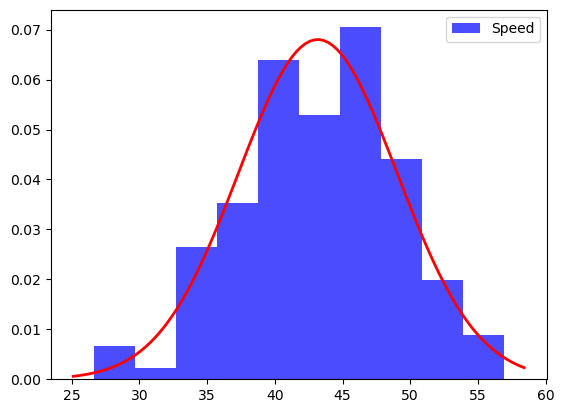

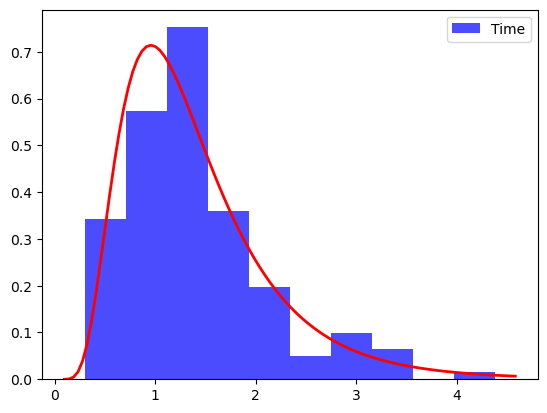

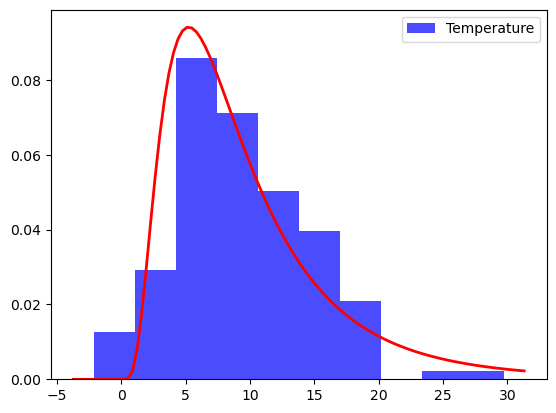

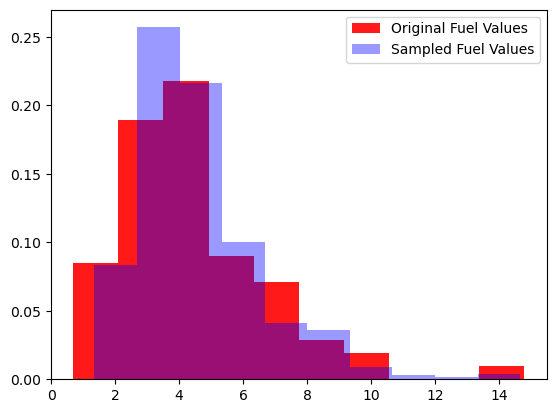

In [138]:
plt.hist(exog['Speed'], bins=10, density=True, alpha=0.7, color='blue', label='Speed')
speed_norm = norm.fit(exog['Speed'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
speed_pdf = norm.pdf(x, *speed_norm)
plt.plot(x, speed_pdf, 'r', linewidth=2)
plt.legend()
plt.show()

plt.hist(exog['Time'], bins=10, density=True, alpha=0.7, color='blue', label='Time')
time_lognorm = lognorm.fit(exog['Time'], floc=0)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
time_pdf = lognorm.pdf(x, *time_lognorm)
plt.plot(x, time_pdf, 'r', linewidth=2)
plt.legend()
plt.show()


plt.hist(exog['Temperature'], bins=10, density=True, alpha=0.7, color='blue', label='Temperature')
temp_lognorm = lognorm.fit(exog[exog['Temperature']>0]['Temperature'], floc=0)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
temp_pdf = lognorm.pdf(x, *temp_lognorm)
plt.plot(x, temp_pdf, 'r', linewidth=2)
plt.legend()
plt.show()

speed_sample = norm.rvs(*speed_norm, size=1000)
time_sample = lognorm.rvs(*time_lognorm, size=1000)
temp_sample = lognorm.rvs(*temp_lognorm, size=1000)

x_pred = np.vstack([speed_sample, time_sample, temp_sample]).T

fuel_samples = model.predict(x_pred)

plt.hist(endog, bins=10, density=True, alpha=0.9, color='red', label='Original Fuel Values')
plt.hist(fuel_samples, bins=10, density=True, alpha=0.4, color='blue', label='Sampled Fuel Values')
plt.legend()
plt.show()

## Question 2
### Part A

In [139]:
data = pd.read_excel('lab_2_data.xlsx', sheet_name='Question2')
melted_data = pd.melt(data, id_vars=['ID'], var_name='age', value_name='weight')
melted_data['age'] = pd.to_numeric(melted_data['age'])
melted_data['weight'] = pd.to_numeric(melted_data['weight'])

### Part B

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: weight    
No. Observations: 3800    Method:             REML      
No. Groups:       100     Scale:              0.9514    
Min. group size:  38      Log-Likelihood:     -5493.0628
Max. group size:  38      Converged:          Yes       
Mean group size:  38.0                                  
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
const         5.974    0.109  54.913 0.000  5.760  6.187
age           0.261    0.001 180.069 0.000  0.258  0.264
Group Var     1.090    0.165                            

MSE: 0.7871679894177583


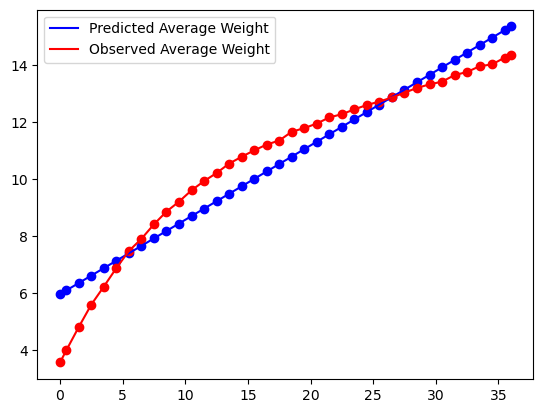

In [140]:
endog = melted_data['weight']
exog = melted_data[['age']]
exog = sm.add_constant(exog)
model = sm.MixedLM(endog, exog, groups=melted_data['ID'])
model_fit = model.fit()
print(model_fit.summary())


observed_avg_weight = melted_data.groupby('age').mean()['weight'].reset_index()

pred_avg_weight = []
for i in observed_avg_weight['age']:
    pred_avg_weight.append(model_fit.predict([1,i])[0])

model_1_mse = mean_squared_error(observed_avg_weight['weight'], pred_avg_weight)
print("MSE:", model_1_mse)

plt.plot(observed_avg_weight['age'].values, pred_avg_weight, color = 'blue', label='Predicted Average Weight')  
plt.scatter(observed_avg_weight['age'].values, pred_avg_weight, color='blue')

plt.plot(observed_avg_weight['age'].values, observed_avg_weight['weight'].values, color = 'red', label='Observed Average Weight')  
plt.scatter(observed_avg_weight['age'].values, observed_avg_weight['weight'].values, color='red')

plt.legend()
plt.show()

Looking at the predicted mean weights for babies from 0 to 36 months, the prediction shows a linear relationship between age and weight, however, looking at the observed average weight, a non-linear pattern is observed, where the babies weight grows much faster in the earlier stages and then seems to slow down after month 15. 

### Part C

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: weight    
No. Observations: 3800    Method:             REML      
No. Groups:       100     Scale:              0.3385    
Min. group size:  38      Log-Likelihood:     -3579.3899
Max. group size:  38      Converged:          Yes       
Mean group size:  38.0                                  
--------------------------------------------------------
              Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
const         1.884    0.109  17.243 0.000  1.670  2.098
log_age       3.297    0.011 312.769 0.000  3.276  3.318
Group Var     1.106    0.276                            

MSE: 0.19058723615763512


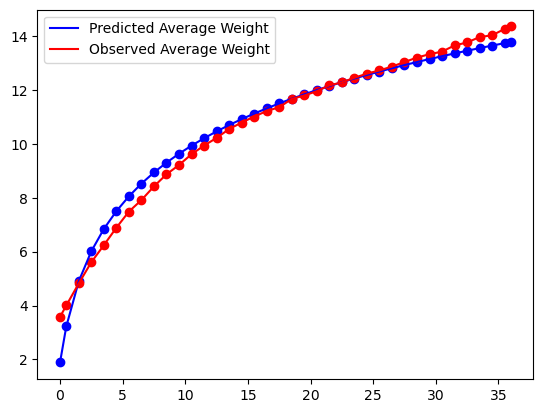

In [141]:
melted_data = pd.melt(data, id_vars=['ID'], var_name='age', value_name='weight')
melted_data['age'] = pd.to_numeric(melted_data['age'])
melted_data['weight'] = pd.to_numeric(melted_data['weight'])

melted_data['log_age'] = np.log(melted_data['age'] + 1)

endog = melted_data['weight']
exog = melted_data[['log_age']]
exog = sm.add_constant(exog)
model_2 = sm.MixedLM(endog, exog, groups=melted_data['ID'])
model_2_fit = model_2.fit()
print(model_2_fit.summary())

observed_avg_weight = melted_data.groupby('log_age').mean()['weight'].reset_index()

pred_avg_weight = []
for i in observed_avg_weight['log_age']:
    pred_avg_weight.append(model_2_fit.predict([1,i])[0])

model_2_mse = mean_squared_error(observed_avg_weight['weight'], pred_avg_weight)
print("MSE:", model_2_mse)

plt.plot(melted_data.groupby('log_age').mean()['age'].values, pred_avg_weight, color = 'blue', label='Predicted Average Weight')  
plt.scatter(melted_data.groupby('log_age').mean()['age'].values, pred_avg_weight, color='blue')

plt.plot(melted_data.groupby('log_age').mean()['age'].values, observed_avg_weight['weight'].values, color = 'red', label='Observed Average Weight')  
plt.scatter(melted_data.groupby('log_age').mean()['age'].values, observed_avg_weight['weight'].values, color='red')

plt.legend()
plt.show()

As seen, the mean squared error is much lower for the 2nd linear mixed effects model, and from the plots, it can be seen the fit is also much closer. In addition, looking at the log-likelihood value from the summaries of both fits, we see a better log-likelihood value for the transformed fit. (-3579 vs -5493)

## Question 3
### Part A

In [142]:
data = pd.read_excel('lab_2_data.xlsx', sheet_name='Question3')
data['Time'] = pd.to_datetime(data['Time'])
d = data
d['Time'] = data['Time'].dt.hour
d = d.sort_values('Time')

### Part B

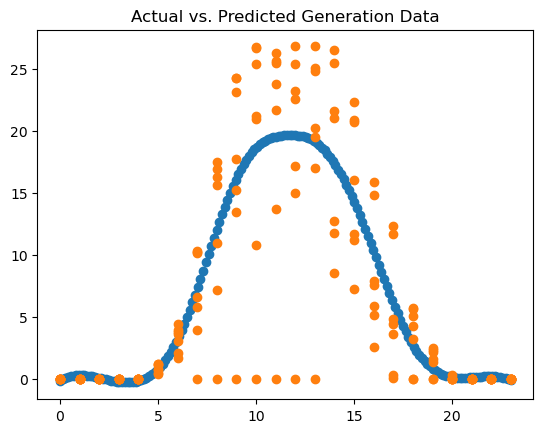

MSE: 23.60253768585545


In [143]:
knots, coefs, degree = interpolate.splrep(d['Time'], d['Generation'], k=3, s=3875)

xr = np.linspace(d['Time'].min(), d['Time'].max(), 168)
spline = interpolate.BSpline(knots, coefs, degree, extrapolate=False)

y_pred = interpolate.splev(xr, (knots, coefs, degree))

plt.scatter(xr, y_pred)
plt.scatter(d['Time'], d['Generation'])
plt.title('Actual vs. Predicted Generation Data')
plt.show()


model_mse = mean_squared_error(d['Generation'], y_pred)
print("MSE:", model_mse)


### Part C

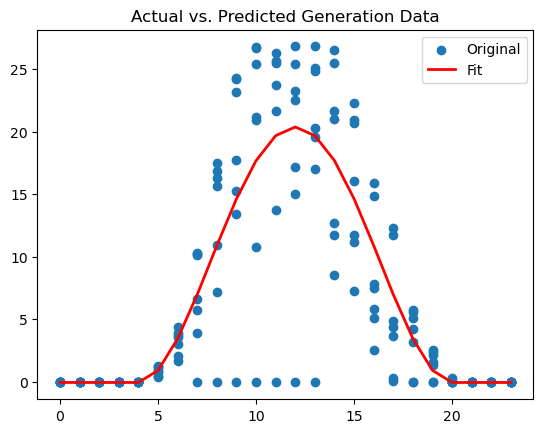

MSE: 23.578687376638623


In [144]:

cos_x = np.cos((d['Time'].values - 12) / 24 * np.pi)

def tpf(x, knot, degree=2):
    return (x > knot) * (x-knot)**degree

x = tpf(cos_x, 0.5)
x = x.reshape(-1,1)

model = LinearRegression()

results = model.fit(x, d['Generation'])

y_pred = model.predict(x)


plt.scatter(d['Time'], d['Generation'], label="Original")
plt.plot(d['Time'].values, y_pred, color='red', linewidth=2, label='Fit')
plt.legend()
plt.title('Actual vs. Predicted Generation Data')
plt.show()

model_mse = mean_squared_error(d['Generation'], y_pred)
print("MSE:", model_mse)

### Part D

Comparing the MSE, I the method in part C has a slightly lower MSE, however, I would choose to use the method in part B because it produced a much smoother curve compared to part c.